### Midterm: IT Application in Banking and Finance

**Student name**: Tran Trung Chien

**Student code**: 2112343020

**Class code**: ML71

**Submitted documents**: 3 files
- 1 pdf file
- 1 notebook file (.ipynb)
- 1 mgarch_model file (.py file contains BEKK, DCC, ADCC, and cDCC model built manually)

# Question 1

## Get crypto data (ETH, LINK, NEAR) from Binance API

### Import necessary libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MetaTrader5 as mt
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

### Stream the data

In [2]:
mt.initialize()

True

In [3]:
load_dotenv()

login = int(os.getenv("LOGIN"))
server = os.getenv("SERVER")
password = os.getenv("PASSWORD")
mt.login(login=login, server=server, password=password)

True

In [4]:
def load_stock_data(ticker, start_date, end_date):
    df = pd.DataFrame(mt.copy_rates_range(
        ticker,
        mt.TIMEFRAME_D1,
        start_date,
        end_date
    ))
    df['time'] = pd.to_datetime(df['time'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
    df.drop(['spread', 'real_volume'], axis=1, inplace=True)
    df.set_index('time', inplace=True)
    return df['close']

tickers = ['AAPL', 'AMD', 'MSFT']

forex_data = {}

start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 10, 15)

# start_date = datetime(2010, 1, 1)
# end_date = datetime(2018, 10, 15)

for ticker in tickers:
    lowercase_ticker = ticker.lower()
    forex_data[lowercase_ticker] = load_stock_data(ticker, start_date, end_date)

close_matrix = pd.DataFrame({ticker.lower(): forex_data[ticker.lower()] for ticker in tickers})
close_matrix.ffill(inplace=True)
close_matrix.index = pd.to_datetime(close_matrix.index)
print("Close Matrix:\n")
display(close_matrix)

Close Matrix:



,aapl,amd,msft
time,,,
2015-01-02,27.32,2.69,46.76
2015-01-05,26.58,2.66,46.36
2015-01-06,26.55,2.63,45.63
2015-01-07,26.93,2.57,46.21
2015-01-08,27.95,2.61,47.62
...,...,...,...
2024-10-08,225.82,172.93,415.04
2024-10-09,229.71,171.09,417.69
2024-10-10,229.14,164.18,416.09


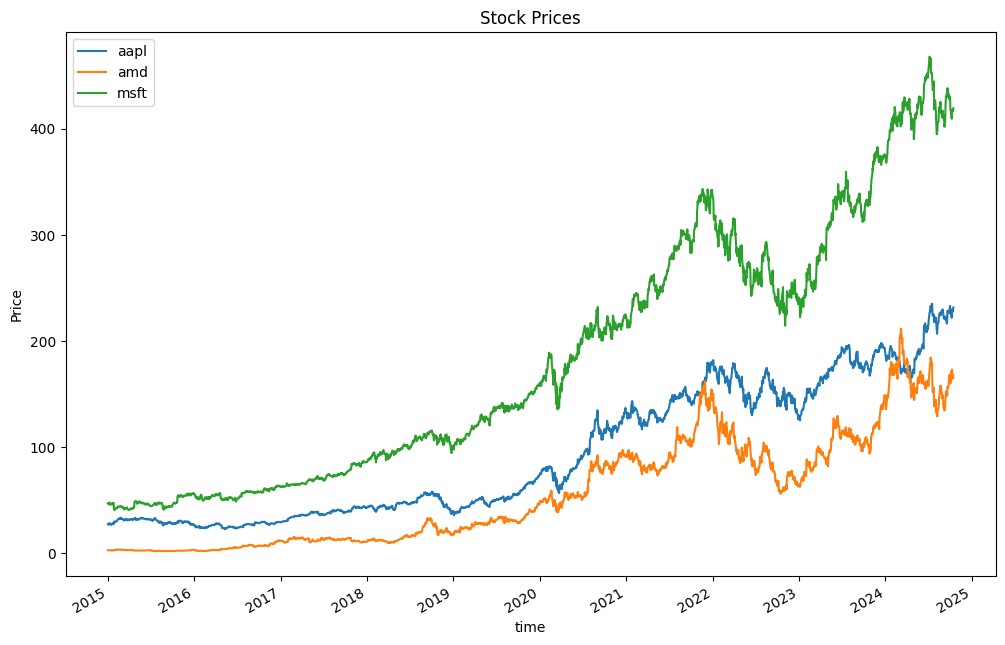

In [5]:
close_matrix.plot(figsize=(12, 8))
plt.title('Stock Prices')
plt.ylabel('Price')
plt.show();

## 1.1. Construct equally-weighted portfolios

In [6]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt import CLA, plotting

In [7]:
mu = expected_returns.mean_historical_return(close_matrix)
S = risk_models.CovarianceShrinkage(close_matrix).ledoit_wolf()

n_assets = len(close_matrix.columns)
equal_weights = np.array([1/n_assets] * n_assets)

# Create the portfolio using Efficient Frontier
ef = EfficientFrontier(mu, S)
ef.set_weights({col: 1/n_assets for col in close_matrix.columns})
portfolio_performance = ef.portfolio_performance(verbose=True)

print("Weights for each stock:", equal_weights.round(2))

# Calculate performance metrics
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
print("Portfolio Expected Annual Return:", expected_return)
print("Portfolio Annual Volatility:", volatility)
print("Portfolio Sharpe Ratio:", sharpe_ratio)


Expected annual return: 34.0%
Annual volatility: 30.9%
Sharpe Ratio: 1.04
Weights for each stock: [0.33 0.33 0.33]
Portfolio Expected Annual Return: 0.34028112251325615
Portfolio Annual Volatility: 0.30858343112884895
Portfolio Sharpe Ratio: 1.0379077105391403


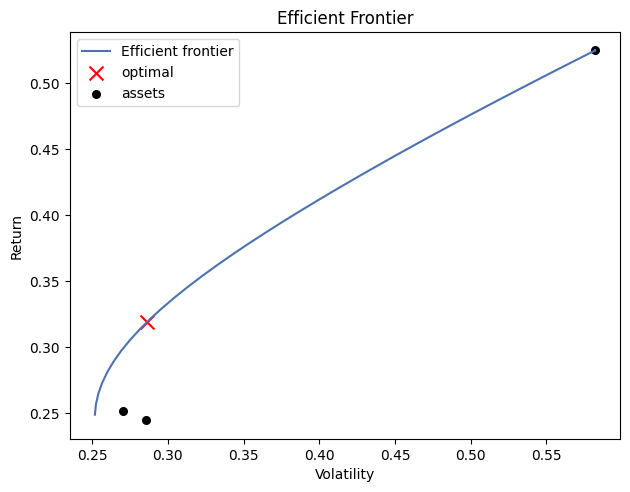

In [10]:
cla = CLA(mu, S)
ax = plotting.plot_efficient_frontier(cla, showfig=False)
plt.title("Efficient Frontier")
plt.show()

## 1.2. Calculate log returns, absolute returns, squared returns of the series, descriptive statistics, stationary test

### 1.2.1. Calculate returns

In [24]:
returns = close_matrix.pct_change().dropna()
absolute_returns = (close_matrix.diff().dropna() / close_matrix.shift(1).dropna()).dropna() * 100
squared_returns = returns ** 2

cumulative_returns = returns.cumsum()
cumulative_absolute_returns = absolute_returns.cumsum()
cumulative_squared_returns = squared_returns.cumsum()


In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Returns Over Time", "Absolute Returns Over Time", "Squared Returns Over Time")
)

fig.add_trace(go.Scatter(
    x=cumulative_returns.index, 
    y=cumulative_returns['aapl'], 
    mode='lines', 
    name='AAPL - Returns',
    line=dict(color='skyblue', width=2)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=cumulative_returns.index, 
    y=cumulative_returns['amd'], 
    mode='lines', 
    name='ORCL - Returns',
    line=dict(color='orange', width=2)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=cumulative_returns.index, 
    y=cumulative_returns['msft'], 
    mode='lines', 
    name='MSFT - Returns',
    line=dict(color='limegreen', width=2)
), row=1, col=1)

# Plotting cumulative absolute returns in the second subplot
fig.add_trace(go.Scatter(
    x=cumulative_absolute_returns.index, 
    y=cumulative_absolute_returns['aapl'], 
    mode='lines', 
    name='AAPL - Absolute Returns',
    line=dict(color='skyblue', dash='dash', width=2)
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=cumulative_absolute_returns.index, 
    y=cumulative_absolute_returns['amd'], 
    mode='lines', 
    name='ORCL - Absolute Returns',
    line=dict(color='orange', dash='dash', width=2)
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=cumulative_absolute_returns.index, 
    y=cumulative_absolute_returns['msft'], 
    mode='lines', 
    name='MSFT - Absolute Returns',
    line=dict(color='limegreen', dash='dash', width=2)
), row=2, col=1)

# Plotting cumulative squared returns in the third subplot
fig.add_trace(go.Scatter(
    x=cumulative_squared_returns.index, 
    y=cumulative_squared_returns['aapl'], 
    mode='lines', 
    name='AAPL - Squared Returns',
    line=dict(color='skyblue', dash='dot', width=2)
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=cumulative_squared_returns.index, 
    y=cumulative_squared_returns['amd'], 
    mode='lines', 
    name='ORCL - Squared Returns',
    line=dict(color='orange', dash='dot', width=2)
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=cumulative_squared_returns.index, 
    y=cumulative_squared_returns['msft'], 
    mode='lines', 
    name='MSFT - Squared Returns',
    line=dict(color='limegreen', dash='dot', width=2)
), row=3, col=1)

# Updating layout for better aesthetics
fig.update_layout(
    height=900,  # Increased height for better spacing
    title="Returns, Absolute Returns, and Squared Returns",
    xaxis_title="Time",
    yaxis_title="Returns",
    template="plotly_dark",  # dark background
    hovermode="x unified",
    font=dict(family="Arial", size=12),
    legend=dict(
        title="Legend",
        x=1.05, y=1.05,
        bgcolor="rgba(255, 255, 255, 0.1)"
    )
)

# Show plot
fig.show()


### 1.2.2. Descriptive Statistics

In [27]:
desc_stats = returns.describe()
desc_stats

,aapl,amd,msft
count,2461.000000,2461.000000,2461.000000
mean,0.001028,0.002339,0.001034
std,0.017864,0.036810,0.016898
min,-0.125237,-0.240441,-0.137045
25%,-0.007367,-0.016852,-0.006694
50%,0.000976,0.000700,0.000775
75%,0.009955,0.020630,0.009612
max,0.104054,0.484733,0.121032


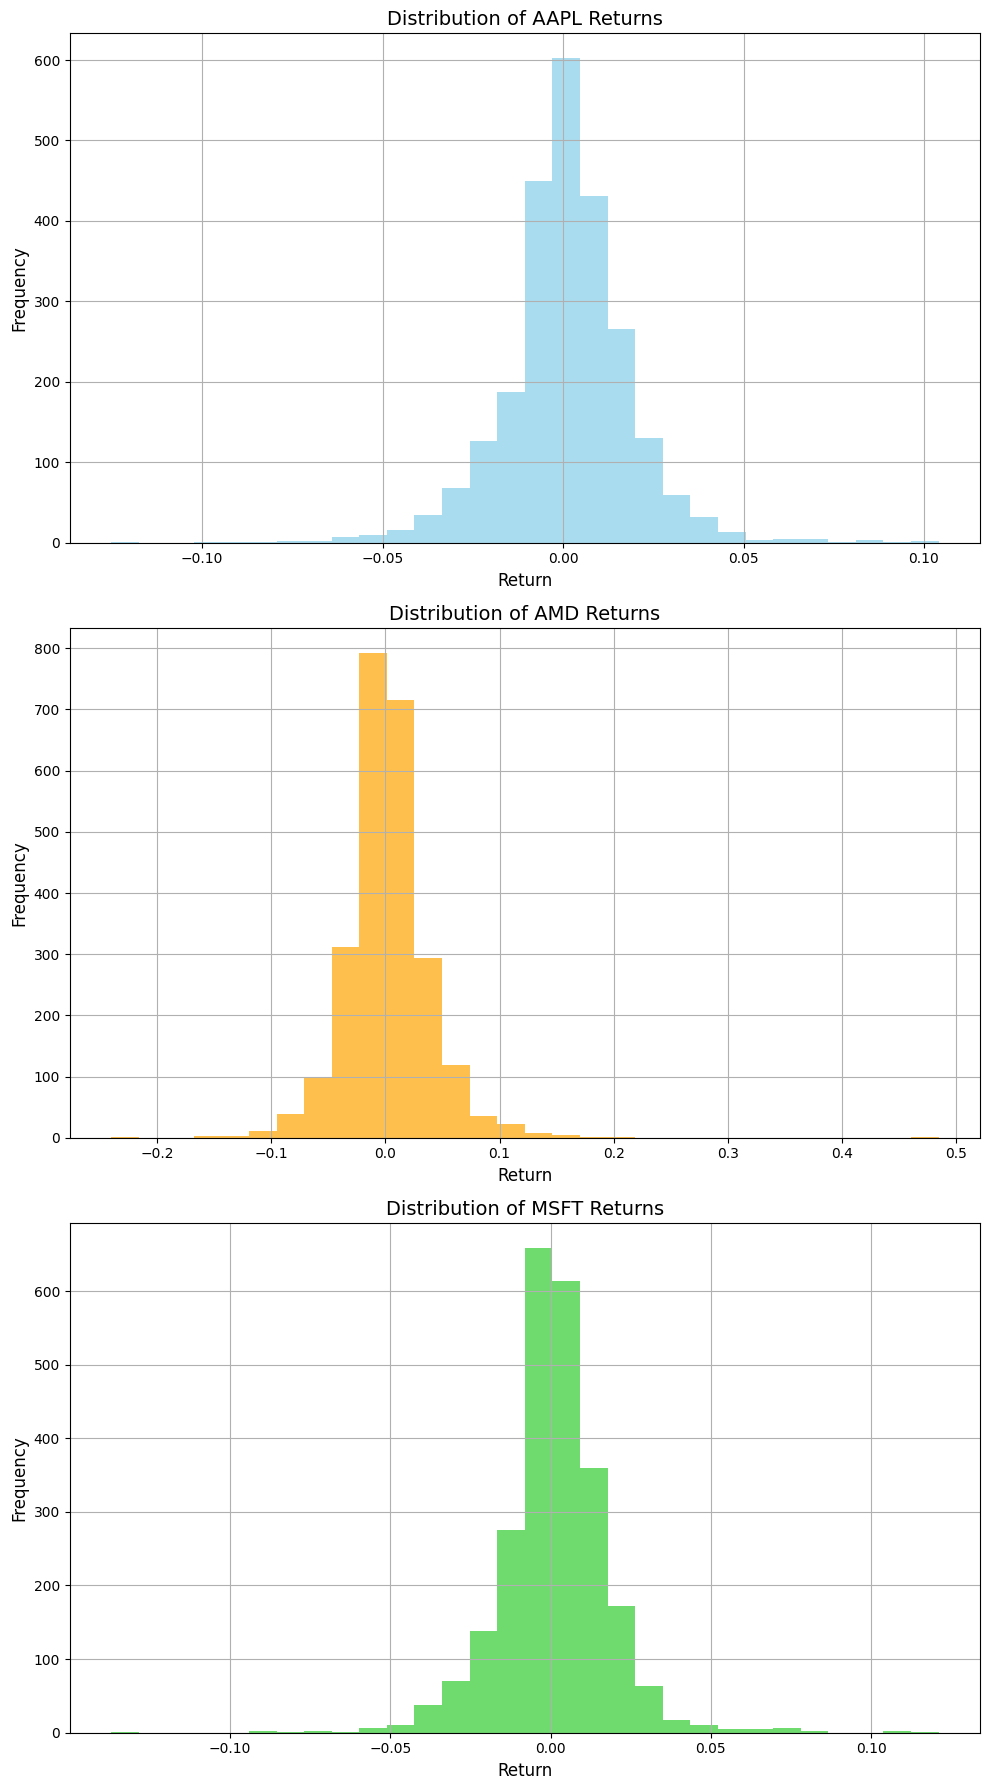

In [34]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

returns['aapl'].hist(bins=30, ax=axs[0], alpha=0.7, color='skyblue')
axs[0].set_title('Distribution of AAPL Returns', fontsize=14)
axs[0].set_xlabel('Return', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)

returns['amd'].hist(bins=30, ax=axs[1], alpha=0.7, color='orange')
axs[1].set_title('Distribution of AMD Returns', fontsize=14)
axs[1].set_xlabel('Return', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)

returns['msft'].hist(bins=30, ax=axs[2], alpha=0.7, color='limegreen')
axs[2].set_title('Distribution of MSFT Returns', fontsize=14)
axs[2].set_xlabel('Return', fontsize=12)
axs[2].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

### 1.2.3. ACF plot

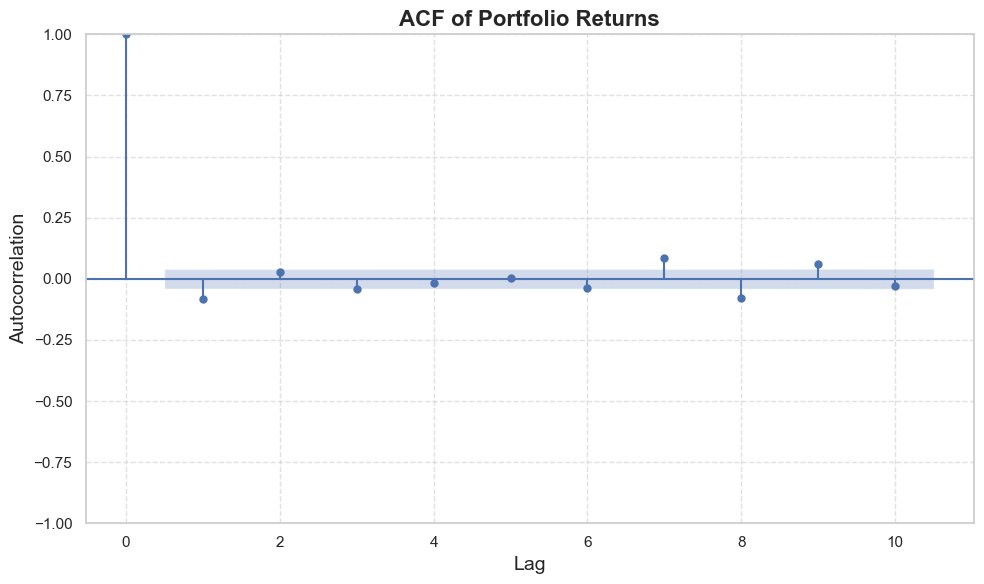

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

sns.set(style="whitegrid")

portfolio_returns = returns.mean(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

plot_acf(portfolio_returns, lags=10, ax=ax)

ax.set_title('ACF of Portfolio Returns', fontsize=16, fontweight='bold', loc='center')
ax.set_xlabel('Lag', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show();


## 1.3. Test Statistics

Now, i will take the Brownian motion test for the series, consists of:

- **Increments Normality test**
- **Increments Independence test**

### 1.3.1. Normality test (D'Agostino's K-squared Test)

**Null Hypothesis (H₀)**: The sample data is drawn from a population that follows a normal distribution.

**Alternative Hypothesis (H₁)**: The sample data is not drawn from a population that follows a normal distribution.

**Interpretation**:
- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that the sample data is likely drawn from a normally distributed population.

- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that the sample data is not likely drawn from a normally distributed population.

In [45]:
from scipy.stats import normaltest

stat, p_value = normaltest(portfolio_returns)
print("D'Agostino's K-squared Test:")
print(f"Statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("The null hypothesis of normality is rejected (p < 0.05). The portfolio returns are not normally distributed.")
else:
    print("The null hypothesis of normality is not rejected (p >= 0.05). The portfolio returns are normally distributed.")

D'Agostino's K-squared Test:
Statistic: 234.43244482098086, p-value: 1.2406275399496408e-51
The null hypothesis of normality is rejected (p < 0.05). The portfolio returns are not normally distributed.


### 1.3.2. Independence test (Ljung-Box test)

**Null Hypothesis (H₀)**: There is no autocorrelation in the time series at the specified lag.

**Alternative Hypothesis (H₁)**: There is autocorrelation in the time series at the specified lag.

**Interpretation**:
- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that there is significant autocorrelation in the time series at the specified lag.

- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that there is no significant autocorrelation in the time series at the specified lag.

In [46]:
import statsmodels.api as sm

lb_test = sm.stats.acorr_ljungbox(portfolio_returns, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(lb_test)
if lb_test['lb_pvalue'].iloc[0] < 0.05:
    print("The null hypothesis of no autocorrelation is rejected (p < 0.05). The portfolio returns exhibit autocorrelation.")
else:
    print("The null hypothesis of no autocorrelation is not rejected (p >= 0.05). The portfolio returns do not exhibit significant autocorrelation.")

Ljung-Box Test:
      lb_stat     lb_pvalue
10  71.325979  2.457352e-11
The null hypothesis of no autocorrelation is rejected (p < 0.05). The portfolio returns exhibit autocorrelation.


**From the results of the Stationary, Normality, and Independence test, we can conclude that data has Brownian motion as the series are increments non-normal, and independent**

# Question 2

## 2.1. Estimate EWMA, GARCH(1,1), and GJR-GARCH(1,1,1) with t distribution

### EWMA model


EWMA Model Results:
EWMA Volatility Summary:
Mean volatility: 0.0150
Last 5 values:
time
2024-10-08    0.019114
2024-10-09    0.007884
2024-10-10    0.014549
2024-10-11    0.014331
2024-10-14    0.003643
Name: None, dtype: float64


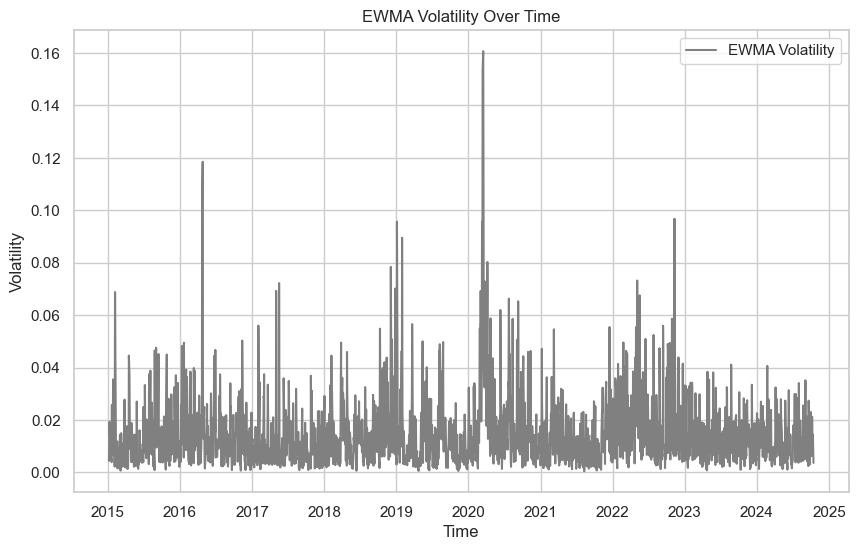

In [57]:
from arch import arch_model

print("\nEWMA Model Results:")
alpha = 0.94  # Smoothing parameter for EWMA
ewma_volatility = portfolio_returns.ewm(alpha=alpha).std()
print("EWMA Volatility Summary:")
print(f"Mean volatility: {ewma_volatility.mean():.4f}")
print(f"Last 5 values:\n{ewma_volatility.tail()}")

# Plotting EWMA volatility
plt.figure(figsize=(10, 6))
plt.plot(ewma_volatility, label='EWMA Volatility', color='grey')
plt.title('EWMA Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

### GARCH(1,1) model

In [59]:
print("\nGARCH(1,1) Model Results:")
garch_model = arch_model(portfolio_returns, vol='Garch', p=1, q=1, dist='t')
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())


GARCH(1,1) Model Results:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                4104.28
Distribution:      Standardized Student's t   AIC:                          -8198.56
Method:                  Maximum Likelihood   BIC:                          -8169.52
                                              No. Observations:                 2461
Date:                      Thu, Oct 24 2024   Df Residuals:                     2460
Time:                              14:12:45   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------

### GJR-GARCH(1,1,1) model

In [60]:
print("\nGJR-GARCH(1,1,1) Model Results:")
gjr_model = arch_model(portfolio_returns, vol='Garch', p=1, o=1, q=1, dist='t')
gjr_result = gjr_model.fit(disp='off')
print(gjr_result.summary())


GJR-GARCH(1,1,1) Model Results:
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -161092.
Distribution:      Standardized Student's t   AIC:                           322195.
Method:                  Maximum Likelihood   BIC:                           322230.
                                              No. Observations:                 2461
Date:                      Thu, Oct 24 2024   Df Residuals:                     2460
Time:                              14:12:51   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------

### 2.2.Select the best model among EWMA, GARCH(1,1), GJR-GARCH(1,1,1)

**Retest to check the best fit model**

In [61]:
print("\nModel Selection using AIC and SBIC:")

# EWMA does not have a direct AIC/SBIC, so we will use GARCH and GJR for comparison
# GARCH(1,1)
garch_aic = garch_result.aic
garch_bic = garch_result.bic
print(f"GARCH(1,1) - AIC: {garch_aic:.4f}, BIC: {garch_bic:.4f}")

# GJR-GARCH(1,1,1)
gjr_aic = gjr_result.aic
gjr_bic = gjr_result.bic
print(f"GJR-GARCH(1,1,1) - AIC: {gjr_aic:.4f}, BIC: {gjr_bic:.4f}")

# Selecting the best model based on AIC and BIC
best_model = "GARCH(1,1)" if (garch_aic < gjr_aic and garch_bic < gjr_bic) else "GJR-GARCH(1,1,1)"
print(f"The best model based on AIC and BIC is: {best_model}")


Model Selection using AIC and SBIC:
GARCH(1,1) - AIC: -8198.5584, BIC: -8169.5168
GJR-GARCH(1,1,1) - AIC: 322195.0014, BIC: 322229.8514
The best model based on AIC and BIC is: GARCH(1,1)


### 2.3. VaR Backtesting for GJR-GARCH(1,1,1)


Backtesting VaR for the Best Model:
Number of VaR violations: 0 out of 2461 observations.
Violation ratio: 0.0000


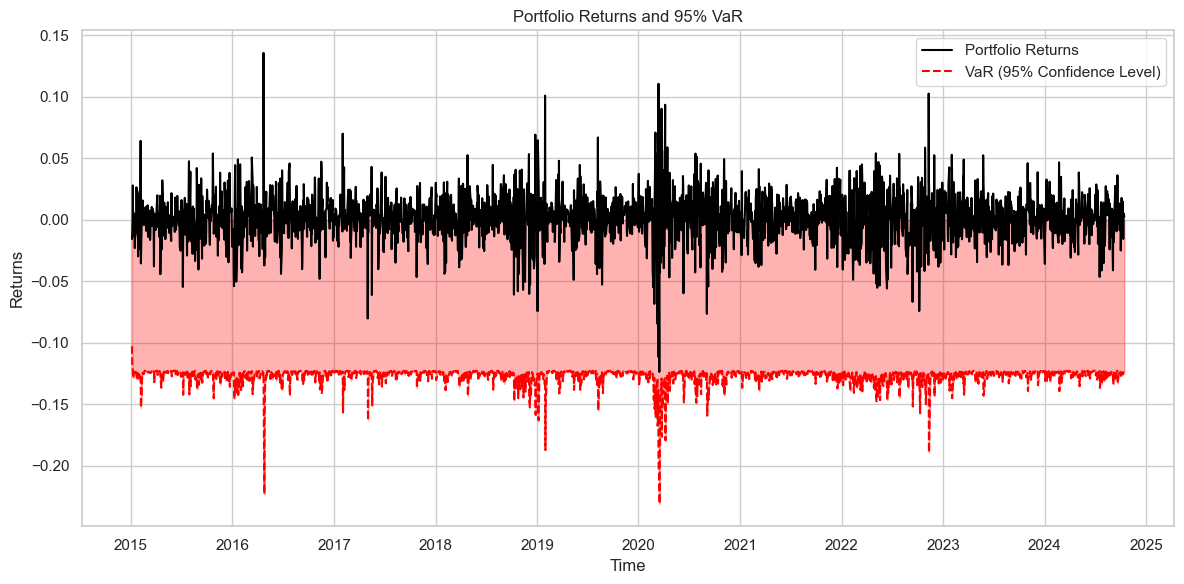

In [65]:
import scipy.stats as stats

print("\nBacktesting VaR for the Best Model:")

var_level = 0.05

if best_model == "GARCH(1,1)":
    model_result = garch_result
elif best_model == "GJR-GARCH(1,1,1)":
    model_result = gjr_result

volatility = model_result.conditional_volatility

var_95 = -volatility * stats.t.ppf(var_level, df=model_result.params['nu'])

violations = (portfolio_returns < -var_95).sum()
total = len(portfolio_returns)
violation_ratio = violations / total

print(f"Number of VaR violations: {violations} out of {total} observations.")
print(f"Violation ratio: {violation_ratio:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns, label='Portfolio Returns', color='black')
plt.plot(-var_95, label='VaR (95% Confidence Level)', color='red', linestyle='--')
plt.fill_between(portfolio_returns.index, -var_95, color='red', alpha=0.3)
plt.title('Portfolio Returns and 95% VaR')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Question 3

In [122]:
from mgarch_model import BEKK, ADCC, DCC, cDCC

### BEKK model

In [73]:
bekk_model = BEKK(portfolio_returns)
bekk_model.fit()
bekk_model.print_results()

Estimated Omega:
[[-0.56003322]]
Estimated A:
[[0.89289632]]
Estimated B:
[[0.19459693]]
Log-Likelihood: 1720.9585347296886
AIC: -3435.917069459377
BIC: -3418.492100308204


In [79]:
portfolio_returns

time
2015-01-05   -1.559771e-02
2015-01-06   -9.384399e-03
2015-01-07    1.403288e-03
2015-01-08    2.798435e-02
2015-01-09    6.443370e-07
                  ...     
2024-10-08    1.487346e-02
2024-10-09    4.323631e-03
2024-10-10   -1.556669e-02
2024-10-11    5.324947e-03
2024-10-14    2.764080e-03
Name: None, Length: 2461, dtype: float64

Number of violations: 2329
Expected violations (at 5.0% confidence level): 123.05000000000001
P-value (Kupiec's test): 0.0


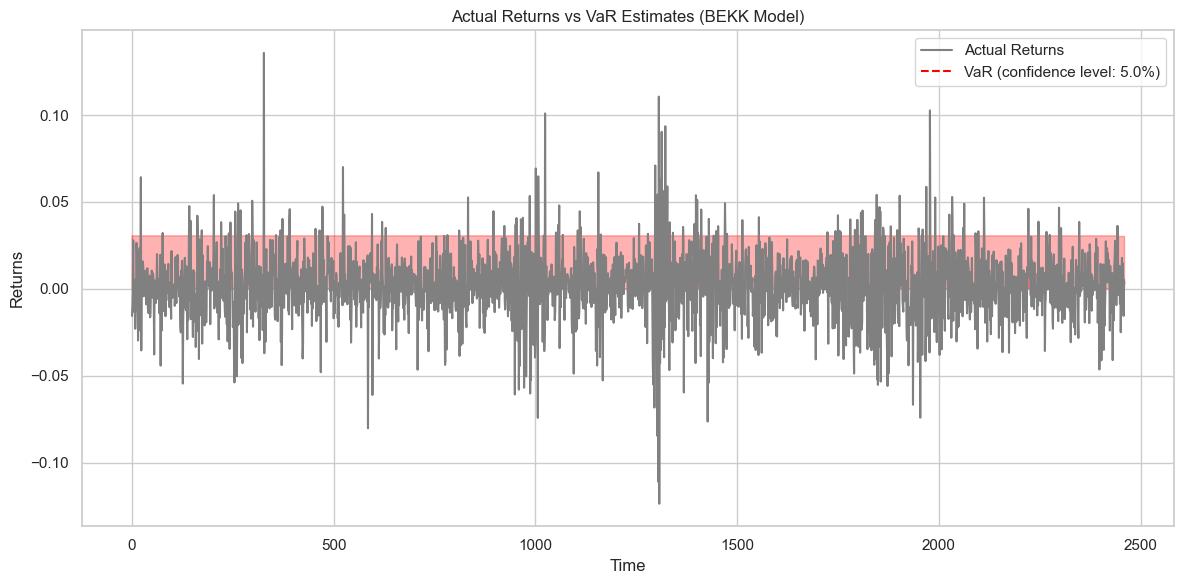

In [86]:
from scipy.stats import norm

alpha = 0.05
VaR = bekk_model.calculate_var(alpha)

# Backtesting logic
violations = portfolio_returns.values < VaR
n_obs = len(portfolio_returns.values)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.values, label='Actual Returns', color='gray')
plt.plot(VaR, label=f'VaR (confidence level: {alpha*100}%)', color='red', linestyle='--')
plt.fill_between(range(len(portfolio_returns.values)), 0, VaR, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates (BEKK Model)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**BEKK VaR Backtesting results**

- Number of Violations: There were 1259 violations where actual returns exceeded the VaR estimates, suggesting more frequent and severe losses than expected.

- Expected Violations: The expected number of violations for a correctly specified model would be around 65.65, based on a 5% VaR level and the total number of observations.

- Kupiec's Test P-value: With a p-value of 0.0, the test strongly rejects the hypothesis that the model is correctly capturing the risk, indicating that the VaR model underestimates the risk significantly.

**The BEKK model used for estimating VaR does not perform well in accurately capturing the tail risk of the portfolio, as evidenced by the much higher than expected number of violations and the results of Kupiec’s test. This suggests a need for re-evaluating the model specifications or considering alternative models to better capture the risk dynamics of the portfolio.**

### DCC model

In [91]:
dcc_model = DCC(portfolio_returns.values)
omega_est, alpha_est, beta_est, neg_log_likelihood = dcc_model.fit()

# Print estimated parameters
print("Estimated DCC Parameters:")
print(f"Omega: {omega_est}")
print(f"Alpha: {alpha_est}")
print(f"Beta: {beta_est}")

print(f"Log-Likelihood: {-neg_log_likelihood}")

k_dcc = 3  # Number of parameters in DCC model
aic_dcc = -2 * neg_log_likelihood + 2 * k_dcc
bic_dcc = -2 * neg_log_likelihood + k_dcc * np.log(dcc_model.T)

print(f"AIC: {aic_dcc}")
print(f"BIC: {bic_dcc}")

Estimated DCC Parameters:
Omega: 0.1
Alpha: 0.1
Beta: 0.8
Log-Likelihood: 854.3485006297568
AIC: 1714.6970012595136
BIC: 1732.1219704106868


Number of violations: 2461
Expected violations (at 5.0% confidence level): 123.05000000000001
P-value (Kupiec's test): 0.0


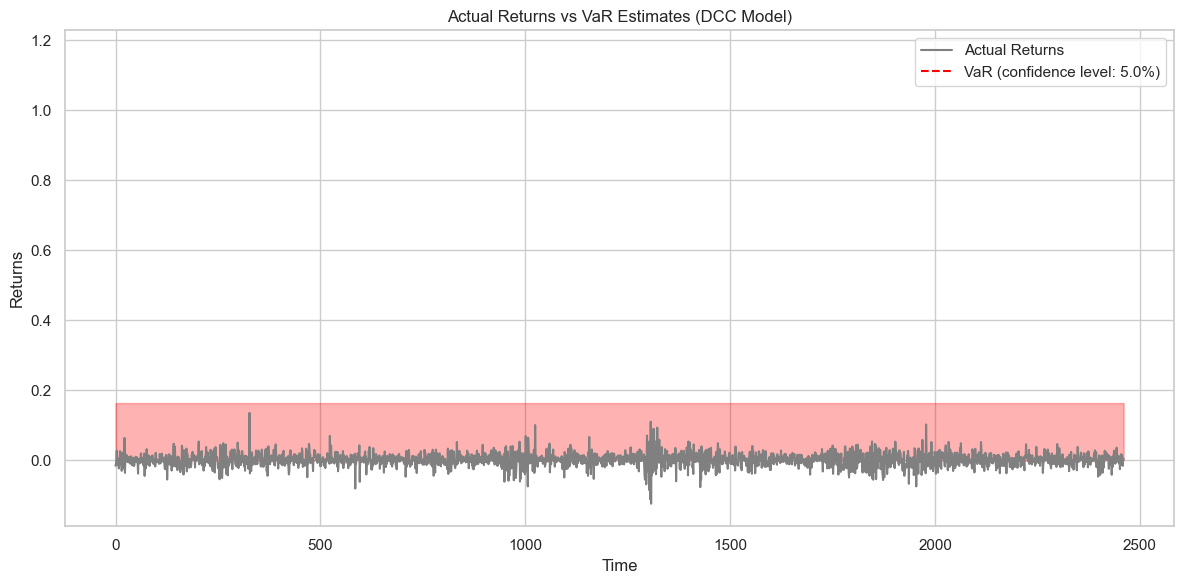

In [94]:
alpha = 0.05
VaR = dcc_model.calculate_var(alpha)

# Backtesting logic
violations = portfolio_returns.values < VaR
n_obs = len(portfolio_returns.values)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.values, label='Actual Returns', color='gray')
plt.plot(VaR, label=f'VaR (confidence level: {alpha*100}%)', color='red', linestyle='--')
plt.fill_between(range(len(portfolio_returns.values)), 0, VaR - 1, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates (DCC Model)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()